In [1]:
"""
Process Name            : STEP 1 : PREPROCESSING DATA
"""
#=======================================================================================================
### Required Imports ###
#============================================================================================================
try:
    import sys  # System-specific parameters and functions
    import logging # for logs
    import socket # network communication
    import warnings  # Warning control
    import os # Interacting with the operating system
    import pandas as pd  # Data manipulation
    import numpy as np  # Numerical operations
    import difflib  # Sequence comparison
    import pycountry  # Country information
    from geopy.geocoders import Nominatim  # Geocoding
    import re  # Regular expressions
    from datetime import datetime  # Date and time
    from matplotlib import colors  # Color utilities
    from spellchecker import SpellChecker  # Spell checking
    from sklearn.model_selection import train_test_split  # Data splitting
    from colour import Color  # Color manipulation
    import nltk  # Natural language processing
    from nltk.corpus import stopwords  # Stopwords list
    import seaborn as sns  # Data visualization
    import matplotlib.pyplot as plt  # Plotting
    import json  # JSON handling
except Exception as err:
    print("Exception raised while importing the packages")
    print(f'Exception: {err}')
    #input("press Enter to Close")
    sys.exit()
    

In [2]:
#=========================================================================
### Initialization ###
#=========================================================================
try:
    path = os.getcwd()
    curr_time = datetime.now()

    ### Log Files declaration ###
    log_folder = os.path.join(path, 'Logs')
    log_date_fmt = str(curr_time.strftime('%Y')) + '-' + str(curr_time.strftime('%m')) + '-' + str(curr_time.strftime('%d')) + "_" + str(curr_time.strftime("%H")) + "-" + str(curr_time.strftime("%M"))

    audit_log_file = "Audit_pre_processing.log"
    audit_log_file = os.path.join(log_folder, audit_log_file)
    
    error_log_file = "Error_pre_processing.log"
    error_log_file = os.path.join(log_folder, error_log_file)

    ### Creating log folder ###
    if not os.path.exists(log_folder):
        os.makedirs(log_folder)
        
    ### Function: Logger setup ###
    def setup_logger(logger_name, log_file, level=logging.INFO):
        logger = logging.getLogger(logger_name)
        formatter = logging.Formatter(socket.gethostname()+' : '+'%(asctime)s : %(levelname)s : [%(filename)s:%(lineno)d] : %(message)s')

        fileHandler = logging.FileHandler(log_file, mode='w')

        fileHandler.setFormatter(formatter)

        streamHandler = logging.StreamHandler(sys.stdout)
        streamHandler.setFormatter(formatter)

        logger.setLevel(level)
        logger.addHandler(fileHandler)
        logger.addHandler(streamHandler)
        return logger
        
    ### Setting up the logger ###
    setup_logger('audit', audit_log_file, level=logging.INFO)
    setup_logger('error', error_log_file, level=logging.ERROR)

    audit_logger = logging.getLogger('audit')
    error_logger = logging.getLogger('error')
    audit_logger.info('Process start')

except Exception as err:
    print('Setting up the logger failed')
    print(f'Exception: {err}')
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 14:39:34,885 : INFO : [3103135885.py:45] : Process start


In [3]:
#==================================================================================================
### Ignore Warnings ### 
#==================================================================================================
try:
    audit_logger.info('Ignore Warnings')
    warnings.filterwarnings('ignore') ## Suppress all warnings
except Exception as err:
    audit_logger.info('Ignore Warnings - Failed')
    error_logger.error('Ignore Warnings - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 14:39:34,889 : INFO : [2561458356.py:5] : Ignore Warnings


In [4]:
#==================================================================================================
### Download NLTK STOPWAORDS ### 
#==================================================================================================
try:
    audit_logger.info('Downloading NLTK STOPWAORDS')
    spell = SpellChecker()
    nltk.download('stopwords') # Download the stopwords from NLTK
    stop_words = set(stopwords.words('english')) # Create a set of English stopwords
except Exception as err:
    audit_logger.info('Downloading NLTK STOPWAORDS - Failed')
    error_logger.error('Downloading NLTK STOPWAORDS - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 14:39:34,893 : INFO : [1589805589.py:5] : Downloading NLTK STOPWAORDS


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutipatkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
#==================================================================================================
### Create folder structure ### 
#==================================================================================================
try:
    audit_logger.info('Create folder structure')
    path
    input_folder = os.path.join(path, 'Input')
    if not os.path.isdir(input_folder):
        audit_logger.info('No input folder')
        error_logger.error('No input folder')
        raise Exception
    excel_folder = os.path.join(path, 'Excel_files')
    if not os.path.isdir(excel_folder):
        os.mkdir(excel_folder)
    saved_folder = os.path.join(path, 'Saved_files')
    if not os.path.isdir(saved_folder):
        os.mkdir(saved_folder)
    output_folder = os.path.join(path, 'Output')
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
except Exception as err:
    audit_logger.info('Create folder structure - Failed')
    error_logger.error('Create folder structure - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 14:39:35,072 : INFO : [300162134.py:5] : Create folder structure


In [6]:
audit_logger.info('Saving Functions') 
# Function to find the best match and its confidence
def get_best_match_with_confidence(country):
    country = country.replace("City", "") #drop word "City
    if "Englan" in country:
        country = "United Kingdom"
    if "rkiye" in country and country.startswith("T"):
        country = "Turkey"
    try:
        try:
            country = alpha_2_mapping[country]
        except:
            pass
        matches = difflib.get_close_matches(country, country_names, n=1)
        if matches:
            best_match = matches[0]
            confidence = difflib.SequenceMatcher(None, country, best_match).ratio() #calculate the confidence level (0 to 1)
            if confidence >= 0.80:
                return best_match, confidence
            else:
                return country, 0            
        else:
            return country, 0
    except:
        return country, 0
    
# Function to calculate age from birthdate
def calculateAge(birthDate):
    try:
        today = datetime.today()
        age = today.year - birthDate.year -((today.month, today.day) <(birthDate.month, birthDate.day))    
    except:
        return None
    return age

# Function to normalize sizes like "4XL" into "XXXXL" for XLs and XSs
def normalize_size(size):
    match = re.match(r"(\d+)(XL)", size.upper().strip())
    match_2 = re.match(r"(\d+)(XS)", size.upper().strip())
    if match:
        number = int(match.group(1))
        return "X" * number + "L"
    elif match_2:
        number = int(match_2.group(1))
        return "X" * number + "S"
    else:
        return size.strip()
    
# Function to convert clothes sizes to numerical values
def convert_size_to_numbers(sizes):
    if pd.isna(sizes):
        return 0
    sizes = sizes.split(',')
    numeric_sizes = [size_mapping[size.strip()] for size in sizes if size.strip() in size_mapping]
    return numeric_sizes if numeric_sizes else None

# Function to convert personality types to numerical values
def convert_personality_to_number(personality):
    for key in personality_mapping:
        if key == personality:
            return personality_mapping[key]
    return 4
    
#Function to get valid color as per capital lettes
def split_by_capital(s):
    if len(s.split(" ")) == 1 and s[0].isupper() and s[1].islower():
        # Split the string at each point a new capital letter starts, except for the very beginning of the string
        parts = re.findall('[A-Z][^A-Z]*', s)
        return parts
    else:
        return s.split(" ")

#Function to extract and convert color to rgba
def custom_to_rgba(name):
    try:
        int32_values = []
        color_name_2=[]
        # Split the string based on capital letters
        color_name = split_by_capital(name)
        color_name  = [i for i in color_name if len(i)>2]
        for i in color_name:
            i = i.rstrip('s') #handle words like "blacks"
            i = i.rstrip('ish') #handle words like "blackish"
            if spell.correction(i.lower()) is None:
                color_name_2.append(i.lower())
            else:
                color_name_2.append(spell.correction(i.lower()))
                color_name_2.append(i.lower().strip())
        color_names_3  = [i for i in color_name_2 if Color(i) is True]
        if len(color_names_3) <= 0:
            color_names_3 = color_name_2
        color_names_3 = list(set(color_names_3))
        for color_name_3 in color_names_3:
            color_name_3 = color_name_3.lower().replace(" ", "").strip()
            #Handle common typo errors
            if color_name_3.startswith("b") and color_name_3.endswith("ck"):
                color_name_3 = "black"
            elif color_name_3.startswith("whit"):
                color_name_3 = "white"
            elif color_name_3.startswith("bl") and color_name_3.endswith("ck") == False:
                color_name_3 = "blue"   
            elif color_name_3.startswith("voil"):
                color_name_3 = "violet" 
            elif color_name_3.startswith("ros") or color_name_3.endswith("ink"):
                color_name_3 = "pink"  
            elif color_name_3.endswith("ojo") or color_name_3.startswith("verm"):
                color_name_3 = "red"   
            elif color_name_3.startswith("verd"):
                color_name_3 = "green"  
            elif color_name_3.startswith("azu"):
                color_name_3 = "blue"
            elif color_name_3.startswith("negr") or color_name_3.startswith("ne"):
                color_name_3 = "black"
            elif color_name_3.startswith("bian"):
                color_name_3 = "white"
            elif color_name_3.startswith("saf") and color_name_3.endswith("on"):
                color_name_3 = "orange"
            elif "denim" in color_name_3 or "jean" in color_name_3:
                color_name_3 = "blue"
            try:
                rgba = colors.to_rgba(color_name_3)
                int32_values.append(list(rgba))
            except:
                #some common color not handled by matplotlib.color module
                if color_name_3 == "mauve":
                    rgba = (213, 184, 255, 1)
                    int32_values.append(list(rgba))
                elif color_name_3.startswith("lil") :
                    rgba = (157,126,183,1.00)
                    int32_values.append(list(rgba))
                elif color_name_3.startswith("peac"):
                    rgba = (255,176,124,1.00)
                    int32_values.append(list(rgba))
                elif color_name_3 == "cream":
                    rgba = (245,239,214,1.00)
                    int32_values.append(list(rgba)) 
                elif (color_name_3.startswith("b") and color_name_3.endswith("ge")) or color_name_3.startswith("offw"):
                    rgba = (245, 245, 220, 1)
                    int32_values.append(list(rgba))
                elif color_name_3 == "burgundy":
                    rgba =(144,0,32,1.00)
                    int32_values.append(list(rgba))
                elif color_name_3 == "nude":
                    rgba =(227, 188, 154, 1.00)
                    int32_values.append(list(rgba))
                elif color_name_3 == "khaki" or color_name_3 == "kakhi" or color_name_3 == "kaki" or color_name_3 == "olive":
                    rgba =(181, 179, 92, 1)
                    int32_values.append(list(rgba))
                elif color_name_3.startswith("sand") or color_name_3 == "mustard":
                    rgba =(231,196,150, 1)
                    int32_values.append(list(rgba))
        if len(int32_values) < 1:
            raise Exception
        else:
            return int32_values
    except Exception:
        rgba = (-1, -1, -1, 1)
        int32_values.append(list(rgba))
        return int32_values

#Function to remove braceted text
def remove_bracketed_text(text):
    if pd.isna(text):
        return text
    return re.sub(r'\(.*?\)', '', text).strip()

# Function to remove stop words
def remove_stop_words(text):
    if pd.isna(text):
        return text
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

#Function to extract type from Clothing_type column
def replace_clothing_type(text):
    text = text.lower()  
    if 'street' in text:
        return 'streetwear'
    elif 'sport' in text:
        return 'sportswear'
    elif 'dress' in text or 'saree' in text or 'sadi' in text or 'traditional' in text or 'religi' in text:
        return 'traditional'
    elif 'offic' in text or 'formal' in text:
        return 'formal'
    elif 'athleisure' in text:
        return 'casual'
    elif 'basic' in text or 'casual' in text or 'smart' in text:
        return 'casual'
    elif 'party' in text:
        return 'partywear'
    elif text in allowed_types:
        return text
    else:
        return "other"
    
#Function to extract type from Preferred_Bottoms column   
def Preferred_Bottoms(text):
    clothing_items = ["skirt","sweatpant", "sweatshorts","koreanpants","formalpants","chinos","straightpants",
                      "joggers","leggings", "any"]
    text = str(text)
    if text in clothing_items:
        return text
    elif 'skirt' in text:
        return 'skirt'
    elif 'sweatpant' in text or 'sweat' in text:
        return 'sweatpants'
    elif 'dress' in text or 'saree' in text or 'sadi' in text or 'traditional' in text or 'religi' in text or "salwar" in text or "burkah" in text:
        return 'traditional'
    elif 'offic' in text or 'formal' in text:
        return 'formalpants'
    elif 'korea' in text:
        return 'koreanpants'
    elif 'chino' in text:
        return 'chinos'
    elif 'straightpant' in text or "denim" in text or "pant" in text or "short" in text:
        return 'straightpants'
    elif 'jogger' in text:
        return 'joggers'
    elif "legging" in text:
        return "leggings"
    elif text == "nan":
        return "nan"
    else:
        return "other"

#Function to extract type from Preferred_Upperwear column   
def Preferred_Upperwear(text):
    text = text.replace(" ", "")
    if "sweat" in "text":
        return "sweatshirt"
    elif 'tshirt' in text:
        return 'tshirt'
    elif 'shirt' in text:
        return 'shirt'
    elif "tee" in text:
        return "tshirt"
    elif "top" in text:
        return "top"
    elif "sadi" in text:
        return "blouse"
    else:
        return text

#Function to extract and convert meaningful text from output columns
def handle_output_columns(df, column_name): 
    print(column_name)
    df[column_name] = df[column_name].apply(lambda x:str(x).lower().replace("-", " ").replace("vegan", "").strip())
    df[column_name] = df[column_name].str.replace(r'\[.*?\]|\(.*?\)', '', regex=True)
    df[column_name] = df[column_name].apply(lambda x: 'any' if 'depend' in x or ' any' in x #handling the option all
                                            or x.startswith("any") or ' every' in x or x.startswith("every") 
                                            or ' any ' in x or x.startswith("all ")
                                            or 'nopreference' in x.replace(" ", "")
                                            or 'noidea' in x.replace(" ", "")
                                            or 'different' in x.replace(" ", "")
                                            or 'donthave' in x.replace(" ", "").replace("'", "")
                                            or 'doesntmatter' in x.replace(" ", "").replace("'", "")
                                            or 'mix' in x.replace(" ", "")
                                            or 'idk' in x.replace(" ", "")
                                            or 'dontknow' in x.replace(" ", "").replace("'", "")
                                            else x)
    df[column_name] = df[column_name].apply(lambda x: 'denim' if 'jean' in x.replace(" ", "") else x)
    df[column_name] = df[column_name].apply(lambda x: 'nan' if 'none' in x.replace(" ", "") else x)
    df[column_name] = df[column_name].apply(lambda x: 'box' if 'square' in x or 'box' in x else x)
    df[column_name] = df[column_name].apply(lambda x: 'round' if 'crew' in x else x)
    df[column_name] = df[column_name].str.split(",")
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" and ") #splitting data 
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split(" or ")  #splitting data 
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("/") #splitting data 
    df = df.explode(column_name)
    df[column_name] = df[column_name].str.split("&") #splitting data 
    df = df.explode(column_name)
    if column_name == "Preferred_Bottoms":
        df[column_name] = df[column_name].apply(Preferred_Bottoms)
        df[column_name] = df.apply(lambda x: Preferred_Bottoms(x["Bottoms_Other_Details"]) 
                              if x[column_name] == "other" or x[column_name] == "nan" else x[column_name],axis=1)
    elif column_name == "Bottoms_Length":
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()[:2]))
    elif column_name == "Bottoms_Fitting" or column_name == "Single_Piece_Fitting":
        df[column_name] = df[column_name].apply(lambda x: x.replace(" ", "").replace("fit", "")) 
    elif column_name == "Preferred_Upperwear":
        df[column_name] = df[column_name].apply(Preferred_Upperwear)
        df[column_name] = df.apply(lambda x: Preferred_Bottoms(x["Upperwear_Other_Details"]) 
                              if x[column_name] == "other" or x[column_name] == "nan" else x[column_name],axis=1)
    elif column_name == "Upperwear_Length" or column_name == "Single_Piece_Length":
        df[column_name] = df[column_name].apply(lambda x: 'regular' if ('no' in x and "long" in x) else x)
        df[column_name] = df[column_name].apply(lambda x: 'regular' if ('medium' in x) else x)
        df[column_name] = df[column_name].apply(lambda x: x.replace("er ", " "))
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x.split()[:1]))
    elif column_name == "Upperwear_Sleeve_Type" or column_name == "Single_Piece_Sleeves":
        df[column_name] = df[column_name].apply(lambda x: x.replace("sleeves", "").strip())
        df[column_name] = df[column_name].apply(lambda x: 'full' if 'roll' in x else x)
        df[column_name] = df[column_name].apply(lambda x: 'full' if 'fold' in x else x)  
    if column_name.find('Color') == -1:
        df[column_name] = df[column_name].apply(lambda x:str(x).lower().replace(" ", "").strip())  
        # Create a mapping from unique values to numerical values
        if column_name == "Single_Piece_Length":
            df[column_name] = df[column_name].replace("above", "above knee")
            df[column_name] = df[column_name].replace("below", "below knee")
            df[column_name] = df[column_name].apply(lambda x: 'short' if ('shirt' in x) else x)
        df[column_name] = df[column_name].replace("nan", "any")
        df[column_name] = df[column_name].replace(np.nan, "any")
        df[column_name].fillna("any")
        preferred_bottoms_mapping = {bottom: idx + 1 for idx, bottom in enumerate(df[column_name].unique())}
        preferred_bottoms_mapping[np.nan] = 0
        # Save each mapping to a JSON file
        with open(os.path.join(saved_folder, column_name+'.json'), 'w') as f:
            json.dump(preferred_bottoms_mapping, f) #Saving data for future mapping
        df[column_name] = df[column_name].map(preferred_bottoms_mapping)
    else:
        #Color Columns
        df[column_name] = df[column_name].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
        df[column_name] = df[column_name].apply(custom_to_rgba)
        if column_name.find("Upperwear") != -1:
            df[column_name] = df.apply(lambda x: custom_to_rgba(x["Upperwear_Other_Details"]) 
                              if x[column_name] == [[-1, -1, -1, 1]] else x[column_name],axis=1)
        elif column_name.find("Bottom") != -1:
            df[column_name] = df.apply(lambda x: custom_to_rgba(x["Bottoms_Other_Details"]) 
                              if x[column_name] == [[-1, -1, -1, 1]] else x[column_name],axis=1)
        else:
            df[column_name] = df.apply(lambda x: custom_to_rgba(x["Clothing_Other_Details"]) 
                              if x[column_name] == [[-1, -1, -1, 1]] else x[column_name],axis=1)
        df[column_name] = df.apply(lambda x: [[0, 0, 0, 1]]
                              if x[column_name] == [[-1, -1, -1, 1]] else x[column_name],axis=1)
        df = df.explode(column_name)
        df[[column_name+'_r', column_name+'_g', column_name+'_b', column_name+'_a']] = pd.DataFrame(df[column_name].tolist(), index=df.index)
    return df


192.168.1.112 : 2024-09-05 14:39:35,109 : INFO : [1627769538.py:1] : Saving Functions


In [7]:
#==================================================================================================
### Load the inputs ### 
#==================================================================================================
try:
    audit_logger.info('Loading inputs') 
    df = pd.read_excel(os.path.join(input_folder, "dataset.xlsx")) #Load Input data
    country_map = pd.read_excel(os.path.join(input_folder, "country_to_lat_long.xlsx")) #load latitude and longitude of countries, counties, states
    
    # Assuming 'Preferred_Clothing' is the target variable
    X = df.drop('What type of clothing you like to wear', axis=1)  # Features
    y = df['What type of clothing you like to wear']  # Target
    
    # Split the data into remaining data and evaluation sets
    X_remaining, X_eval, y_remaining, y_eval = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)
    
    # Merge back X_eval and y_eval into a single DataFrame and save as excel
    eval_df = pd.concat([X_eval, y_eval], axis=1)
    eval_df.to_excel(os.path.join(excel_folder, "evaluation_data.xlsx"), index=False)
    
    # Merge back remaining data into a single DataFrame for training and testing
    df = pd.concat([X_remaining, y_remaining], axis=1)
    
    # dictionary to map the current column names to new names
    new_column_names = {'Country of Birth': 'Country_of_Birth',
        'Country of Residence': 'Country_of_Residence',
        'Birthdate': 'Birthdate',
        'Gender': 'Gender',
        'Approximate weight in kilogram': 'Weight_kg',
        'Approximate height in centimetre': 'Height_cm',
        'What type of clothes you prefer to wear': 'Preferred_Clothing_Type',
        'How do you define yourself': 'Personality',
        'Size of clothes you wear': 'Clothing_Size',
        'What is your favourite color.': 'Favourite_Color',
        'Do you think this color looks best on you and boost your confidence?': 'Color_Boost_Confidence',
        'Which color do you think looks best on you and makes you feel confident?': 'Best_Color_Confidence',
        'What type of clothing you like to wear': 'Preferred_Clothing',
        'What is your preferred bottoms': 'Preferred_Bottoms',
        'Material preferred for your bottoms?': 'Bottoms_Material',
        'Length of bottoms you prefer?': 'Bottoms_Length',
        'How do you prefer the fitting of your bottoms?': 'Bottoms_Fitting',
        'Which color of bottoms would you prefer. (Please mention two colours)': 'Bottoms_Color',
        'Any other specific detail about the bottoms you will like to mention?': 'Bottoms_Other_Details',
        'What is your prefered upperwear on the selected bottoms?': 'Preferred_Upperwear',
        'What material you will prefer for the upperwear?': 'Upperwear_Material',
        'What length of upperwear would you choose?': 'Upperwear_Length',
        'What is your prefered neckline for them?': 'Upperwear_Neckline',
        'What is your preferred sleeve type?': 'Upperwear_Sleeve_Type',
        'What pattern will you like on you upperwear?': 'Upperwear_Pattern',
        'which type of print': 'Upperwear_Print_Type',
        'What is your preferred color for the selected upperwear to go on the selected bottoms?Please select two)': 'Upperwear_Color',
        'Any other specific detail about the upper wear?': 'Upperwear_Other_Details',
        'Favourite type of single piece wear': 'Favourite_Single_Piece',
        'What is your preferred material?': 'Single_Piece_Material',
        'How do you prefer the fitting?': 'Single_Piece_Fitting',
        'What is your preferred length?': 'Single_Piece_Length',
        'How will you prefer your sleeves?': 'Single_Piece_Sleeves',
        'How would you prefer your neckline?': 'Single_Piece_Neckline',
        'What is your preferred pattern?': 'Single_Piece_Pattern',
        'which type of print.1': 'Single_Piece_Print_Type',
        'Would you prefer the colour which you have mentioned in previous section?': 'Single_Piece_Preferred_Color',
        'What color would you like to choose for you single piece wear': 'Single_Piece_Color',
        'Any other specific detail about the clothing?': 'Clothing_Other_Details',
        'Do you like to wear outer layer on top?': 'Outer_Layer_Preference',
        'What type of outer layer you prefer to wear': 'Preferred_Outer_Layer',
        'What is your preferred material?.1': 'Outer_Layer_Material',
        'How do you prefer the fitting?.1': 'Outer_Layer_Fitting',
        'What is your preferred length?.1': 'Outer_Layer_Length',
        'How will you prefer your sleeves?.1': 'Outer_Layer_Sleeves',
        'How would you prefer your neckline?.1': 'Outer_Layer_Neckline',
        'Type of closing ': 'Outer_Layer_Closing_Type',
        'What color would you like to choose?': 'Outer_Layer_Color',
        'What is your preferred pattern?.1': 'Outer_Layer_Pattern',
        'which type of print.2': 'Outer_Layer_Print_Type',
        'Any other specific detail about the outer layer?': 'Outer_Layer_Other_Details'}
    
    # Define a mapping from size to a numerical value
    size_mapping = {'XXXXXS': 1, 'XXXXS': 2, 'XXXS': 3, 'XXS': 4, 'XS': 5, 'S': 6, 'M': 7, 'L': 8,
                    'XL': 9, 'XXL': 10, 'XXXL': 11, 'XXXXL': 12, 'XXXXXL': 13}

    # Define the mapping for the 'Personality' column
    personality_mapping = {'Introvert (Are you shy, reticent person?)': 1,
        'Ambivert (Are you able to balance between extrovert and introvert?)': 2,
        'Extrovert (Are you outgoing, socially confident?)': 3,}

    # Define the mapping for the 'Cothing_Type' column
    allowed_types = ['semiformal', 'casual', 'formal', 'partywear', 'traditional', 'sportswear', 'streetwear']
    
    # Define the mapping for the 'Preferred_clothing' column
    preferred_clothing_mapping = {'Single Piece Wear': 0, 'Two Piece Wear': 1}

    #output columns
    columns_to_process = ['Preferred_Bottoms', 'Bottoms_Material', 'Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color', 
        'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 'Upperwear_Sleeve_Type', 
        'Upperwear_Pattern', 'Upperwear_Color', 'Favourite_Single_Piece', 'Single_Piece_Material', 
        'Single_Piece_Fitting', 'Single_Piece_Length', 'Single_Piece_Sleeves', 'Single_Piece_Neckline', 
        'Single_Piece_Pattern', 'Single_Piece_Color']
    
    # Rename the columns in the DataFrame
    df.rename(columns=new_column_names, inplace=True)
    df.drop(columns=["Timestamp", "Consent Form:\nI have read the description and accompanying Information Sheet relating to the project on Personality Based Outfit Selection System and understand that participation is entirely voluntary and that I have the right to withdraw from the project any time, and that this will be without detriment. This application has been reviewed by the University Research Ethics Committee and has been given a favourable ethical opinion for conduct.", "Please read the document carefully and proceed with th consent form."], inplace=True)

    #handle country names
    country_name_dic = {"Uk":"United Kingdom", 
                                    "Usa": "United States",
                                    "Us":"United States",
                                    "America":"United States",
                                    "United States Of America": "United States",
                                    "United State Of America" : "United States",
                                    "United States Of American":"United States",
                                   "England": "United Kingdom",
                                   "Wales":"United Kingdom",
                                   "Scotland":"United Kingdom",
                                   "Ksa": "Saudi Arabia",
                                   "Rsa": "South Africa",
                                   "Great Britain":"United Kingdom",
                                   "Britain": "United Kingdom",
                                   "Uae":"United Arab Emirates",
                                   "United Kingdom Of Great Britain And Northern Ireland":"United Kingdom",
                                "Mumbai":"India",
                                "Czechia": "Czech Republic",
                                "Bharat":"India",
                                "Edinburgh":"United Kingdom",
                                "Korea":"South Korea",
                                "Russian Federation": "Russia",
                                "Thane":"India",
                                "Dubai": "United Arab Emirates",
                                "Democratic Republic Of Congo": "Congo",
                                "Europe":"United Kingdom",
                                "Italia":"Italy",
                                "Sssr" : "Russia"}

except Exception as err:
    audit_logger.info('Loading inputs - Failed')
    error_logger.error('Loading inputs - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

192.168.1.112 : 2024-09-05 14:39:35,167 : INFO : [2502993044.py:5] : Loading inputs


In [8]:
#==================================================================================================
### Data Preprocessing ### 
#==================================================================================================
try:
    audit_logger.info('Data Preprocessing')
    #Handling values based on "Yes" and "No" in certain columns
    df.loc[df['Country_of_Residence'] == 'Same as Country of Birth', 'Country_of_Residence'] = df['Country_of_Birth']
    df.loc[df['Color_Boost_Confidence'] == 'Yes', 'Best_Color_Confidence'] = df['Favourite_Color']
    df.loc[df['Single_Piece_Preferred_Color'] == 'Yes', 'Single_Piece_Color'] = df['Color_Boost_Confidence']

    #Processing for country names
    df["Country_of_Birth"] = df["Country_of_Birth"].astype(str)
    df["Country_of_Residence"] = df["Country_of_Residence"].astype(str)   
    df["Country_of_Birth"] = df["Country_of_Birth"].str.strip().str.title()
    df["Country_of_Residence"] = df["Country_of_Residence"].str.strip().str.title()
    
    # Create a list of official country names
    country_names = [country.name for country in pycountry.countries]
    alpha_2_mapping = {country.alpha_2.title(): country.name.title() for country in pycountry.countries}
    
    df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
    df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: x.split(",")[-1] if isinstance(x, str) else x)
    df["Country_of_Birth"] = df["Country_of_Birth"].str.title()
    df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x:x.replace("The ", ""))
    df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x:"Us" if x.find("America") != -1 else x)
    
    df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
    df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: x.split(",")[-1] if isinstance(x, str) else x)
    df["Country_of_Residence"] = df["Country_of_Residence"].str.title()
    df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x:x.replace("The ", ""))
    df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x:"Us" if x.find("America") != -1 else x)
    
    df["Country_of_Birth"] = df["Country_of_Birth"].replace(country_name_dic)
    
    df["Country_of_Residence"] = df["Country_of_Residence"].replace(country_name_dic)
    
    # Replace blank, NaN, or unreadable entries in 'Country_of_Birth' with 'Country_of_Residence' and vice versa
    df["Country_of_Birth"] = df["Country_of_Birth"].apply(lambda x: np.nan if isinstance(x, str) and x.strip() in ['', 'Cannot Read Text'] else x)
    df["Country_of_Residence"] = df["Country_of_Residence"].apply(lambda x: np.nan if isinstance(x, str) and x.strip() in ['', 'Cannot Read Text'] else x)
    df["Country_of_Birth"].fillna(df["Country_of_Residence"], inplace=True)
    df["Country_of_Residence"].fillna(df["Country_of_Birth"], inplace=True)
    
    # Get the unique values
    unique_countries_1 = list(df['Country_of_Birth'].unique())
    unique_countries_2 = list(df['Country_of_Residence'].unique())
    unique_countries = np.union1d(unique_countries_1, unique_countries_2)
    
    # Apply the function to the unique values
    matched_countries = {country: get_best_match_with_confidence(country) for country in unique_countries}
    
    # Create two new columns in the DataFrame by mapping the results back to the original columns
    df['Country_of_Birth'] = df['Country_of_Birth'].apply(lambda x: matched_countries[x][0] if x in matched_countries else x)
    df['Country_of_Residence'] = df['Country_of_Residence'].apply(lambda x: matched_countries[x][0] if x in matched_countries else x)

    # Get the unique values
    unique_countries_1 = list(df['Country_of_Birth'].unique())
    unique_countries_2 = list(df['Country_of_Residence'].unique())
    unique_countries = np.union1d(unique_countries_1, unique_countries_2)
    
    country_map['name'] = country_map['name'].str.strip().str.lower().str.replace(' ', '', regex=True).str.replace(r"\s*\([^()]*\)", "", regex=True)
    country_map = country_map.drop_duplicates(subset=['name'])
    countries_normalized = np.char.replace(np.char.strip(np.char.lower(unique_countries)), ' ', '')
    
    # Create a dictionary from the DataFrame for quick lookup
    country_dict = dict(zip(country_map['name'], zip(country_map['latitude'], country_map['longitude'])))
    
    # Map the countries in the array to their coordinates using the dictionary
    coordinates = [country_dict.get(country, (None, None)) for country in countries_normalized]
    coordinates_df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'], index=unique_countries).reset_index()
    df = df.merge(coordinates_df, left_on='Country_of_Birth', right_on='index')
    df.drop(columns=["index", "Country_of_Birth"], inplace=True)
    df.rename(columns={'Latitude': 'birthplace_lat', 'Longitude': 'birthplace_lon'}, inplace=True)
    df = df.merge(coordinates_df, left_on='Country_of_Residence', right_on='index')
    df.drop(columns=["index", "Country_of_Residence"], inplace=True)
    df.rename(columns={'Latitude': 'resi_lat', 'Longitude': 'resi_lon'}, inplace=True)
    #handle na values                                                        
    df['resi_lat'].fillna(df['birthplace_lat'], inplace=True)
    df['birthplace_lat'].fillna(df['resi_lat'], inplace=True)
    df['resi_lon'].fillna(df['birthplace_lon'], inplace=True)
    df['birthplace_lon'].fillna(df['resi_lon'], inplace=True)

    #get pattern information
    df['Single_Piece_Pattern'] = df['Single_Piece_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
    df['Upperwear_Pattern'] = df['Upperwear_Pattern'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
    df = df.explode('Single_Piece_Pattern')
    df = df.explode('Upperwear_Pattern')
    pattern_1 = list(df['Single_Piece_Pattern'].unique())
    pattern_2 = list(df['Upperwear_Pattern'].unique())
    patterns = np.union1d(pattern_1, pattern_2)

    mapping_pattern = {}
    for pattern in patterns:
        i=pattern.lower()
        if pattern not in ['solid color', 'printed', 'stripes vertical','stripes horizontal', "tye die", "polka dots"]:
            if ("solid") in i or (i.startswith("pla")) or ("simple" in i):
                mapping_pattern[pattern] = "solid color"
            elif "print" in i:
                mapping_pattern[pattern] = "printed"
            elif "floral" in i or "flower" in i:
                mapping_pattern[pattern] = "floral printed"
            elif "graphic" in i or "logo" in i or "design" in i or "band" in i or "brand" in i:
                mapping_pattern[pattern] = "graphic printed"
            elif "che" in i or "box" in i or "block" in i or "cube" in i:
                mapping_pattern[pattern] = "box printed"
            elif "animal" in i:
                mapping_pattern[pattern] = "animal printed"
            elif "anime" in i:
                mapping_pattern[pattern] = "anime printed"  
            else:
                mapping_pattern[pattern] = "Not defined"
                        
    df['Single_Piece_Pattern'] = df['Single_Piece_Pattern'].replace(mapping_pattern)
    df['Upperwear_Pattern'] = df['Upperwear_Pattern'].replace(mapping_pattern)
    
    
    df["Temp"] = df['Upperwear_Other_Details'].replace(mapping_pattern)
    df["Upperwear_Pattern"] = df.apply(lambda x: x["Upperwear_Other_Details"] 
                                  if x["Upperwear_Pattern"] == "Not defined"  else x["Upperwear_Pattern"],axis=1)
        
    df["Temp"] = df['Clothing_Other_Details'].replace(mapping_pattern)
    df["Single_Piece_Pattern"] = df.apply(lambda x: x["Clothing_Other_Details"]
                                  if x["Single_Piece_Pattern"] == "Not defined"  else x["Single_Piece_Pattern"],axis=1)
    
    df['Upperwear_Print_Type'] = df['Upperwear_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
    df['Single_Piece_Print_Type'] = df['Single_Piece_Print_Type'].apply(lambda x: re.split(r'\s*(?:and|or|,|/)\s*', str(x)))
    df = df.explode('Upperwear_Print_Type')
    df = df.explode('Single_Piece_Print_Type')
    
    pattern_1 = list(df['Upperwear_Print_Type'].unique())
    pattern_2 = list(df['Single_Piece_Print_Type'].unique())
    patterns = np.union1d(pattern_1, pattern_2)
    
    mapping_pattern = {}
    for pattern in patterns:
        i=str(pattern).lower() 
        if "floral" in i or "flower" in i:
            mapping_pattern[pattern] = "floral printed"
        elif "graphic" in i or "logo" in i or "design" in i or "band" in i or "brand" in i or "image" in i or "mark" in i or "pictur" in i or "3d" in i or "art in i":
            mapping_pattern[pattern] = "graphic printed"
        elif "text" in i or "letter" in i or "sent" in i or "name" in i or "phrase" in i:
            mapping_pattern[pattern] = "text printed"
        elif "abstract" in i or "random" in i or "graffiti" in i:   
            mapping_pattern[pattern] = "abstract printed" 
        elif "geom" in i:   
            mapping_pattern[pattern] = "geometric printed"  
        elif "che" in i or "box" in i or "block" in i or "cube" in i:
            mapping_pattern[pattern] = "box printed"
        elif "anima" in i or "leopard" in i or "snake" in i or "cheeta" in i:
            mapping_pattern[pattern] = "animal printed"
        elif "cartoon" in i or "hero" in i or "face" in i or "game" in i:
            mapping_pattern[pattern] = "cartoon/game printed"
        elif "anime" in i:
            mapping_pattern[pattern] = "anime printed" 
        elif "print" in i:
            mapping_pattern[pattern] = "anything printed"
        else:
            mapping_pattern[pattern] = "Not defined printed"
            
    df['Upperwear_Print_Type'] = df['Upperwear_Print_Type'].replace(mapping_pattern)
    df['Single_Piece_Print_Type'] = df['Single_Piece_Print_Type'].replace(mapping_pattern)
    
    df["Temp"] = df['Upperwear_Other_Details'].replace(mapping_pattern)
    df["Upperwear_Print_Type"] = df.apply(lambda x: x["Upperwear_Other_Details"]
                                  if x["Upperwear_Print_Type"] == "anything printed" or  x["Upperwear_Print_Type"] == "Not defined printed"
                                else x["Upperwear_Print_Type"],axis=1)
        
    df["Temp"] = df['Clothing_Other_Details'].replace(mapping_pattern)
    df["Single_Piece_Print_Type"] = df.apply(lambda x: x["Clothing_Other_Details"]
                                  if x["Single_Piece_Print_Type"] == "anything printed" or  x["Single_Piece_Print_Type"] == "Not defined printed"
                                else x["Single_Piece_Print_Type"],axis=1)
    
    df.reset_index(inplace=True)
    df.loc[df['Upperwear_Pattern'] == 'printed', 'Upperwear_Pattern'] = df['Upperwear_Print_Type']
    df.loc[df['Single_Piece_Pattern'] == 'printed', 'Single_Piece_Pattern'] = df['Single_Piece_Print_Type']
         
    # Age, weight and height calculation
    df['Birthdate'] = pd.to_datetime(df['Birthdate'], errors='coerce')
    df['Age'] = df['Birthdate'].apply(calculateAge)
    df['Weight_kg'] = df['Weight_kg'].apply(lambda x: x * 100 if x < 1 else x)
    df['Weight_kg'] = df['Weight_kg'].apply(lambda x: x * 10 if x < 10 else x)
    df["Weight_kg"] = df["Weight_kg"].round(0)
    df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 100 if x < 2 else x)
    df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 30.48 if x < 15 else x)
    df['Height_cm'] = df['Height_cm'].apply(lambda x: x * 2.54 if x < 100 else x)
    df["Height_cm"] = df["Height_cm"].round(0)
    
    # Normalize the sizes in the 'Size of clothes you wear' column
    df['Clothing_Size'] = df['Clothing_Size'].apply(lambda sizes: ','.join([normalize_size(size) for size in sizes.split(',')]))
    df['Clothing_Size'] = df['Clothing_Size'].apply(convert_size_to_numbers)
    
    # Apply the function to the personality column
    df['Personality'] = df['Personality'].apply(convert_personality_to_number)

    #handle favourite color and best color
    df['Favourite_Color'] = df['Favourite_Color'].str.split(',')
    df['Best_Color_Confidence'] = df['Best_Color_Confidence'].str.split(',')
    df = df.explode('Favourite_Color')
    df = df.explode("Clothing_Size")
    df = df.explode("Best_Color_Confidence")
    df["Favourite_Color"] = df["Favourite_Color"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x) if isinstance(x, str) else x)
    df['Favourite_Color'] = df['Favourite_Color'].apply(custom_to_rgba)
    df["Favourite_Color"] = df.apply(lambda x: [[0, 0, 0, 1]]
                                  if x["Favourite_Color"] == [[-1, -1, -1, 1]] else x["Favourite_Color"],axis=1)
    df["Best_Color_Confidence"] = df["Best_Color_Confidence"].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x) if isinstance(x, str) else x)
    df['Best_Color_Confidence'] = df['Best_Color_Confidence'].apply(custom_to_rgba)
    df["Best_Color_Confidence"] = df.apply(lambda x: [[0, 0, 0, 1]]
                                  if x["Best_Color_Confidence"] == [[-1, -1, -1, 1]] else x["Best_Color_Confidence"],axis=1)                                                             
    df = df.explode('Favourite_Color')
    df = df.explode("Best_Color_Confidence")
    df[['Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b', 'Favourite_Color_a']] = pd.DataFrame(df['Favourite_Color'].tolist(), index=df.index)
    df[['Best_Color_Confidence_r', 'Best_Color_Confidence_g', 'Best_Color_Confidence_b', 'Best_Color_Confidence_a']] = pd.DataFrame(df['Favourite_Color'].tolist(), index=df.index)

    #handle gender column
    df['Gender'] = df['Gender'].apply(lambda x: 1 if x.lower() == 'male' else (3 if x.lower() == 'female' else 2))

    #handle preferred_Clothing_type
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:str(x).lower().strip())
    # Apply the function to a specific column, e.g., 'Preferred_Clothing_Type'
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(remove_bracketed_text)
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:x.replace("both", "").replace("combination", "").replace("smart", ""))
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split('and')
    df = df.explode("Preferred_Clothing_Type")
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split('/')
    df = df.explode("Preferred_Clothing_Type")
    # Apply the function to a specific column, e.g., 'How do you define yourself'
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(remove_stop_words)
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(lambda x:x.replace(" ", ""))
    # Apply the function to the cleaned column
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].apply(replace_clothing_type)
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].str.split(',')
    df = df.explode('Preferred_Clothing_Type')
    clothing_type_mapping = {clothing_type: idx + 1 for idx, clothing_type in enumerate(allowed_types)}
    with open(os.path.join(saved_folder,'Preferred_Clothing_Type.json'), 'w') as f:
        json.dump(clothing_type_mapping, f) # # Save the mapping dictionary to a JSON file
    df['Preferred_Clothing_Type'] = df['Preferred_Clothing_Type'].map(clothing_type_mapping)
    
    #handle preferred_clothing
    df['Preferred_Clothing'] = df['Preferred_Clothing'].map(preferred_clothing_mapping)
    
    # Apply the conversion function to each output column in the list
    for column in columns_to_process:
        df = handle_output_columns(df, column)

    #List of columns to be set to 0
    columns_to_set = ['Preferred_Bottoms', 'Bottoms_Material', 'Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color_r', 'Bottoms_Color_g', 
                  'Bottoms_Color_b', 'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 
                  'Upperwear_Sleeve_Type', 'Upperwear_Pattern', 'Upperwear_Color_r', 'Upperwear_Color_g', 'Upperwear_Color_b']

    # Apply the condition and set the specified columns to 0 where the condition is met
    df.loc[df['Preferred_Clothing'] == 0, columns_to_set] = 0

    #List of columns to be set to 0
    columns_to_set=['Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length', 'Single_Piece_Sleeves', 
                    'Single_Piece_Neckline', 'Single_Piece_Pattern','Single_Piece_Color_r','Single_Piece_Color_g', 'Single_Piece_Color_b']

    # Apply the condition and set the specified columns to 0 where the condition is met
    df.loc[df['Preferred_Clothing'] == 1, columns_to_set] = 0
        
    df = df[['Gender', 'Weight_kg', 'Height_cm','Preferred_Clothing_Type', 'Personality', 'Clothing_Size',
            'Preferred_Clothing','Favourite_Color_r', 'Favourite_Color_g', 'Favourite_Color_b',
           'Best_Color_Confidence_r', 'Best_Color_Confidence_g','Best_Color_Confidence_b', 'Preferred_Bottoms', 
            'Bottoms_Material','Bottoms_Length', 'Bottoms_Fitting', 'Bottoms_Color_r', 'Bottoms_Color_g', 
            'Bottoms_Color_b', 'Preferred_Upperwear', 'Upperwear_Material', 'Upperwear_Length', 'Upperwear_Neckline', 
            'Upperwear_Sleeve_Type', 'Upperwear_Pattern', 'Upperwear_Color_r','Upperwear_Color_g','Upperwear_Color_b',
             'Favourite_Single_Piece', 'Single_Piece_Material', 'Single_Piece_Fitting', 'Single_Piece_Length', 
             'Single_Piece_Sleeves', 'Single_Piece_Neckline', 'Single_Piece_Pattern','Single_Piece_Color_r',
             'Single_Piece_Color_g', 'Single_Piece_Color_b' , 'birthplace_lat','birthplace_lon', 'resi_lat', 
             'resi_lon', 'Age']]
    df.drop_duplicates(inplace=True)
    df.fillna(0, inplace=True)

except Exception as err:
    audit_logger.info('Data Preprocessing - Failed')
    error_logger.error('Data Preprocessing - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()


192.168.1.112 : 2024-09-05 14:39:36,036 : INFO : [90867062.py:5] : Data Preprocessing
Preferred_Bottoms
Bottoms_Material
Bottoms_Length
Bottoms_Fitting
Bottoms_Color
Preferred_Upperwear
Upperwear_Material
Upperwear_Length
Upperwear_Neckline
Upperwear_Sleeve_Type
Upperwear_Pattern
Upperwear_Color
Favourite_Single_Piece
Single_Piece_Material
Single_Piece_Fitting
Single_Piece_Length
Single_Piece_Sleeves
Single_Piece_Neckline
Single_Piece_Pattern
Single_Piece_Color


192.168.1.112 : 2024-09-05 15:01:03,726 : INFO : [1461558778.py:5] : Handling outliers


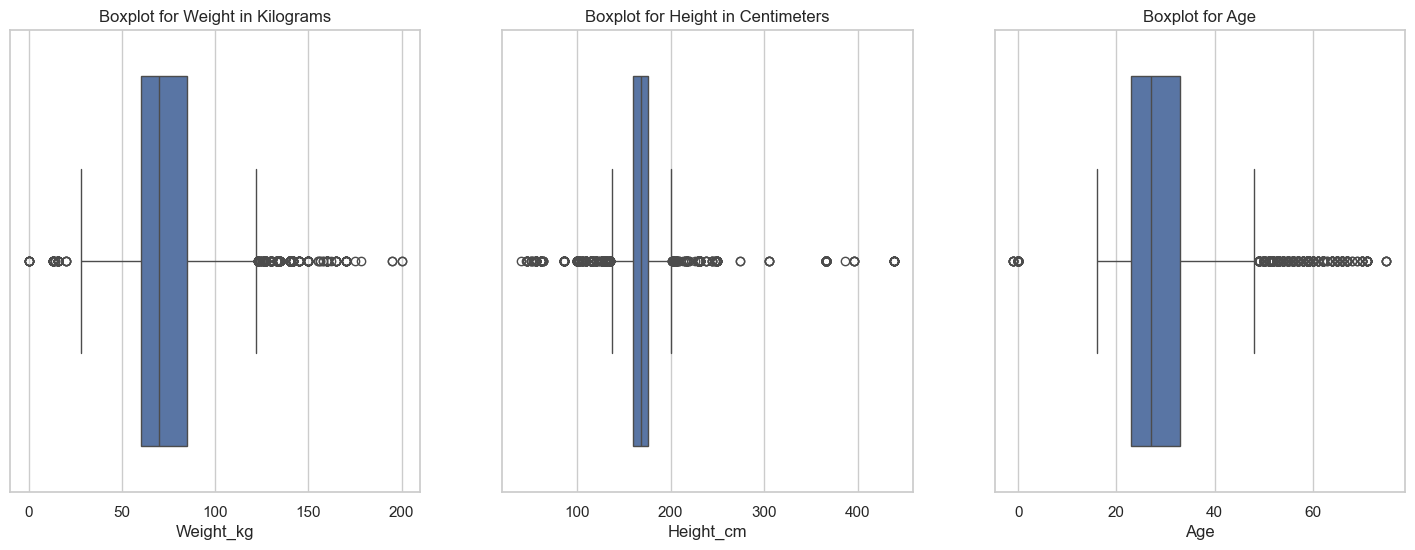

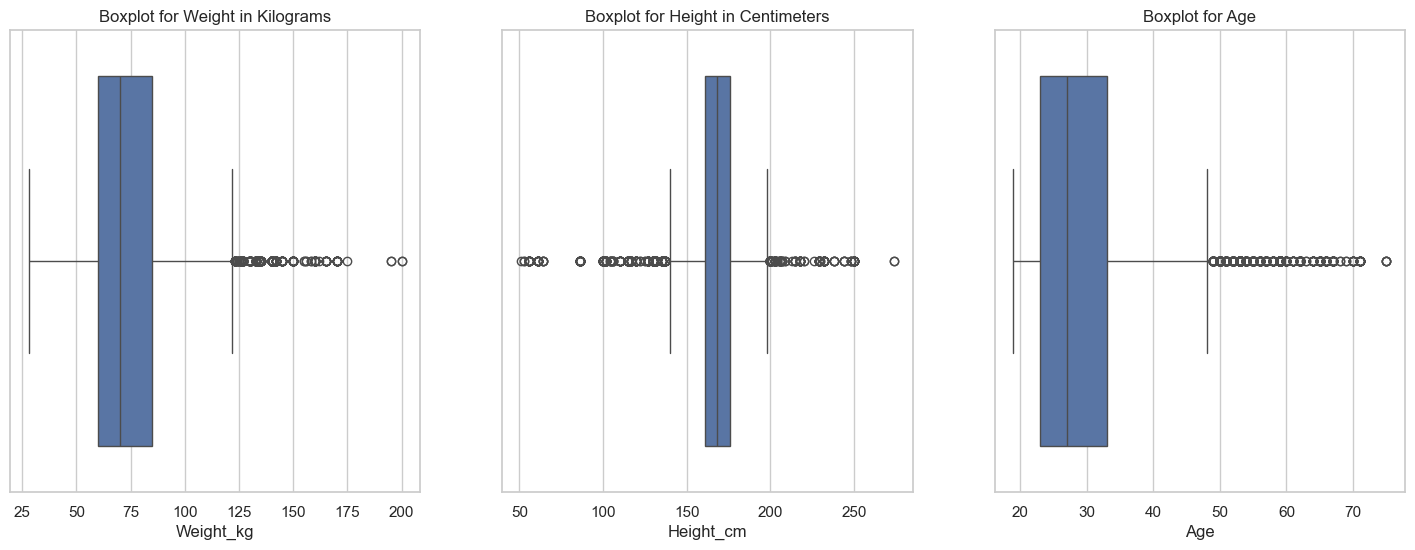

In [9]:
#==================================================================================================
### Handling outliers ### 
#==================================================================================================
try:
    audit_logger.info('Handling outliers')
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 6))
    
    # Subplot for Weight in Kilograms
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
    sns.boxplot(x=df['Weight_kg'])
    plt.title('Boxplot for Weight in Kilograms')
    
    # Subplot for Height in Centimeters
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    sns.boxplot(x=df['Height_cm'])
    plt.title('Boxplot for Height in Centimeters')
    
    # Subplot for Age
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
    sns.boxplot(x=df['Age'])
    plt.title('Boxplot for Age')
    
    plt.savefig(os.path.join(saved_folder,'outliers.png'), format='png', dpi=300)  
    plt.show()

    #handling outliers
    df = df[df["Height_cm"] < 300]
    df = df[df["Height_cm"] > 50]
    df = df[df["Weight_kg"] > 25]
    df = df[df["Age"] > 18]
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(18, 6))
    
    # Subplot for Weight in Kilograms
    plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
    sns.boxplot(x=df['Weight_kg'])
    plt.title('Boxplot for Weight in Kilograms')
    
    # Subplot for Height in Centimeters
    plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
    sns.boxplot(x=df['Height_cm'])
    plt.title('Boxplot for Height in Centimeters')
    
    # Subplot for Age
    plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
    sns.boxplot(x=df['Age'])
    plt.title('Boxplot for Age')
    
    # Save the figure
    plt.savefig(os.path.join(saved_folder,'removed_outliers.png'), format='png', dpi=300) 
    plt.show()
except Exception as err:
    audit_logger.info('Handling outliers - Failed')
    error_logger.error('Handling outliers - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()

In [10]:
#==================================================================================================
### Saving train test data ### 
#==================================================================================================
try:
    audit_logger.info('Saving train test data')
    df.to_excel(os.path.join(excel_folder, "preprocessed_data.xlsx"), index=False)
except Exception as err:
    audit_logger.info('Saving train test data - Failed')
    error_logger.error('Saving train test data - Failed')
    error_logger.error('Exception: ', exc_info=True)
    #input("press Enter to Close")
    sys.exit()


192.168.1.112 : 2024-09-05 15:01:05,621 : INFO : [1711672269.py:5] : Saving train test data


In [11]:
audit_logger.info('Process run success')
total_time = datetime.now() - curr_time
audit_logger.info(f'Total time taken = {total_time}')

192.168.1.112 : 2024-09-05 15:01:15,808 : INFO : [2214019538.py:1] : Process run success
192.168.1.112 : 2024-09-05 15:01:15,808 : INFO : [2214019538.py:3] : Total time taken = 0:21:40.923859
